In [39]:
import os
import cv2
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms


In [40]:
db_file = "/content/drive/MyDrive/images.hdf5"
categories = ['Rococo', 'Art_Nouveau_Modern']
print (categories[0])

Rococo


In [41]:
def load_images(db_file, categories):
    f = h5py.File(db_file, "r")
    images = {}
    for category in categories:
        image_group = np.array(f[f'{category}/images'][:300])
        label_group = np.array(f[f'{category}/meta'][:300])
        print(len(label_group))

        images[category] = {
            "images": image_group,
            "labels": label_group
            
        }
    #images.append([np.array(img), np.eye(2)[1]])
    f.close()
    return images

In [42]:
images = load_images(db_file, categories)

300
300


In [43]:
def reformat_images(image_dict):
    all_images = []
    all_labels = []
    category_lengths = [len(v['images']) for _, v in image_dict.items()]
    min_cat_len = min(category_lengths)

    for k, v in image_dict.items():
        image_list = v['images']
        all_images.extend([t_image for i, t_image in enumerate(image_list) if i < min_cat_len])
        if k == categories[0]:
          k = np.eye(2)[0]
        else: k = np.eye(2)[1]
        all_labels.extend([k for i, _ in enumerate(image_list) if i < min_cat_len])

    all_images = torch.Tensor([i for i in all_images]).view(-1, 3, 224, 224)
    print(len(all_images))
    all_labels = torch.Tensor([i for i in all_labels])
    print(len(all_labels))
    

    return all_images, all_labels

In [44]:

#print(type(re_images))
#print(str(re_images[1][0]))
#print(type(re_images[0][0]))
#print(len(re_images[0][0]))
#plt.imshow(re_images[0][100])
#print(re_images[1][0])


In [ ]:
print(images['Rococo']['images'])
print(images['Art_Nouveau_Modern']['images'])

In [55]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(3,224,224).view(-1,3,224,224)
    self._to_linear = None
    self.convs(x)
    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))


    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return F.softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=73728, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [46]:
#print(X_train.shape)

In [56]:
re_images = reformat_images(images)

X = re_images[0]
y = re_images[1]
X = X/255.0

print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()
#X_test = torch.Tensor([i for i in X_test]).view(-1, 3, 224, 224)
#X_train = torch.Tensor([i for i in X_train]).view(-1, 3, 224, 224)
#print(X_test.shape)


#y_train =  torch.Tensor([i for i in y_train])
#y_test =  torch.Tensor([i for i in y_test])




600
600
torch.Size([600, 3, 224, 224])
torch.Size([198, 3, 224, 224])


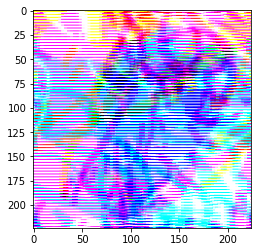

In [57]:
plt.imshow(X_train[0].permute(1, 2, 0)  )
plt.show()

In [63]:
BATCH_SIZE = 100
EPOCHS = 10

for epoch in range(EPOCHS):
  for i in tqdm(range(0, len(X_train), BATCH_SIZE)):
    #print(X_train[i:i+BATCH_SIZE].view(-1, 224, 224).shape)
    X_batch = X_train[i:i+BATCH_SIZE].view(-1, 3, 224, 224)
    y_batch = y_train[i:i+BATCH_SIZE]

    net.zero_grad()
    outputs = net(X_batch)
    loss = loss_function(outputs, y_batch )
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch+1}. Loss: {loss}")


100%|██████████| 5/5 [00:50<00:00, 10.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.00020478444639593363



100%|██████████| 5/5 [00:50<00:00, 10.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2. Loss: 1.5854746379773133e-05



100%|██████████| 5/5 [00:50<00:00, 10.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.0001394774590153247



100%|██████████| 5/5 [00:50<00:00, 10.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4. Loss: 3.903727701981552e-05



100%|██████████| 5/5 [00:50<00:00, 10.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5. Loss: 9.635270544094965e-06



100%|██████████| 5/5 [00:50<00:00, 10.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6. Loss: 8.894566235539969e-06



100%|██████████| 5/5 [00:50<00:00, 10.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7. Loss: 6.362072895171877e-07



100%|██████████| 5/5 [00:50<00:00, 10.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8. Loss: 2.824365026299347e-07



100%|██████████| 5/5 [00:50<00:00, 10.12s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9. Loss: 7.751131647637521e-08



100%|██████████| 5/5 [00:50<00:00, 10.11s/it]

Epoch: 10. Loss: 8.896621217502343e-09


In [64]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        real_class = torch.argmax(y_test[i])
        net_out = net(X_test[i].view(-1, 3 , 224, 224))[0]
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))


100%|██████████| 198/198 [00:11<00:00, 16.88it/s]

Accuracy:  0.768
